# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Model](#5.4_Load_Model)
  * [5.5 Load Data](#5.5_Load_Data)
  * [5.10 Summary](#5.10_Summary)
  * [5.11 Further work](#5.11_Further_work)


## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, we now examine some models to examine their performances.

## 5.3 Imports<a id='5.3_Imports'></a>

In [28]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel

import missingno as msno


import datetime

from library.sb_utils import save_file

## 5.5 Load Data<a id='5.5_Load_Data'></a>

In [2]:
ecg_data = pd.read_csv('../data/ecg_data_step3_features_uncorrelated85.csv')
ecg_data.head()

,t0,t1,t6,t7,t139,Target
0,-0.112522,-2.827204,-2.181408,-1.818287,0.193137,1.0
1,-1.100878,-3.996840,-1.566126,-0.992258,-1.436250,1.0
2,-0.567088,-2.593450,-1.742940,-1.490658,-0.421797,1.0
3,0.490473,-1.914407,-2.993280,-1.671131,-0.383564,1.0
4,0.800232,-0.874252,-2.534510,-1.783423,1.421456,1.0


In [3]:
# Show model's performance

def model_results(model, y_train, y_tr_pred, y_test, y_te_pred, show_training_result=True ):

    print( model)
    print('-------------------------------------')
    if show_training_result:
        print("Classification Report for Training Data")
        print(classification_report(y_train, y_tr_pred, target_names=['ABNORMAL','NORMAL']))
    print('-------------------------------------')
    print("Classification Report for Test Data")
    print(classification_report(y_test, y_te_pred, target_names=['ABNORMAL','NORMAL']))


In [4]:
# Plot Model's ROC

def plot_ROC(model,X, y, title_method ):
    
    logit_roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='{} (area = {:2.2%})'.format(title_method,logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [5]:
#  train and test a model 

def train_test_model(model, grid_params, X_train, y_train, X_test, y_test, model_name):
    pipe = make_pipeline(
    StandardScaler(),
    model
    )

    rskf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle=False)
    model_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=rskf, n_jobs=-1)
    # print(model_grid_cv.get_params().keys())
    # print(model_grid_cv)
    model_grid_cv.fit(X_train, y_train)
    
    y_tr_pred = model_grid_cv.predict(X_train)
    y_te_pred = model_grid_cv.predict(X_test)
    


    if model_name in ['Random Forest', 'K_Neighbors'] :
        show_training_result = False
    else:
        show_training_result= True
    model_results(model_name, y_train, y_tr_pred, y_test, y_te_pred,show_training_result )  
    plot_ROC(model_grid_cv, X_test, y_test, model_name)

    row_model = {'model_name':model_name, 'Accuracy on training data':accuracy_score(y_tr_pred, y_train), 'Accuracy on test data':accuracy_score(y_te_pred, y_test),
'Precision score on training data':precision_score(y_train, y_tr_pred), 'Precision score  on test data':precision_score( y_test, y_te_pred), 
'Recall score on training data':recall_score(y_train, y_tr_pred), 'Recall score  on test data':recall_score( y_test, y_te_pred), 
'F1 score on training data':f1_score(y_train, y_tr_pred), 'F1 score  on test data':f1_score( y_test, y_te_pred), 
'Classification Report for Training Data':classification_report(y_train, y_tr_pred, target_names=['ABNORMAL','NORMAL']), 
'Classification Report for Test Data':classification_report(y_test, y_te_pred, target_names=['ABNORMAL','NORMAL']), 
'best_params_':model_grid_cv.best_params_

    }
    return(row_model) 



In [6]:
X_train, X_test, y_train, y_test = train_test_split(ecg_data.drop(columns='Target'), 
                                                    ecg_data.Target, test_size=0.2,
                                                    stratify= ecg_data.Target,random_state=47)

print(X_train.shape, y_train.shape, X_test.shape,  y_test.shape)

(3998, 5) (3998,) (1000, 5) (1000,)


c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Logistic Regression
-------------------------------------
Classification Report for Training Data
              precision    recall  f1-score   support

    ABNORMAL       0.92      0.90      0.91      1663
      NORMAL       0.93      0.95      0.94      2335

    accuracy                           0.92      3998
   macro avg       0.92      0.92      0.92      3998
weighted avg       0.92      0.92      0.92      3998

-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.92      0.88      0.90       416
      NORMAL       0.92      0.94      0.93       584

    accuracy                           0.92      1000
   macro avg       0.92      0.91      0.92      1000
weighted avg       0.92      0.92      0.92      1000



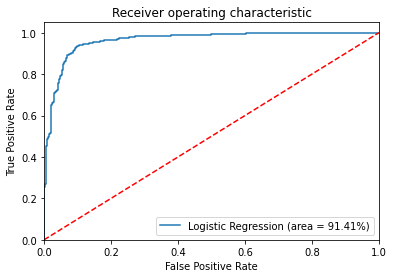

c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Random Forest
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.94      0.91      0.92       416
      NORMAL       0.94      0.96      0.95       584

    accuracy                           0.94      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.94      0.94      1000



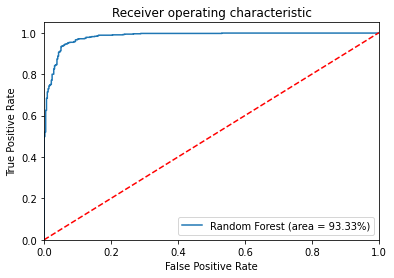

c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


K_Neighbors
-------------------------------------
-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.94      0.94      0.94       416
      NORMAL       0.96      0.95      0.95       584

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



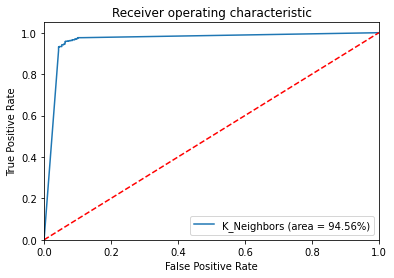

c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBoost
-------------------------------------
Classification Report for Training Data
              precision    recall  f1-score   support

    ABNORMAL       1.00      0.99      0.99      1663
      NORMAL       0.99      1.00      1.00      2335

    accuracy                           1.00      3998
   macro avg       1.00      1.00      1.00      3998
weighted avg       1.00      1.00      1.00      3998

-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.97      0.92      0.94       416
      NORMAL       0.94      0.98      0.96       584

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



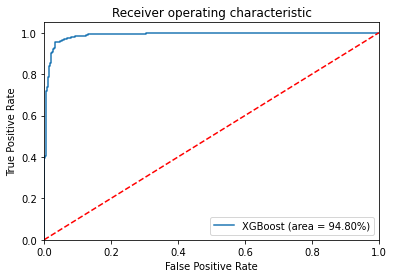

c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
c:\Users\armag\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Non Deep NN
-------------------------------------
Classification Report for Training Data
              precision    recall  f1-score   support

    ABNORMAL       0.97      0.97      0.97      1663
      NORMAL       0.98      0.98      0.98      2335

    accuracy                           0.98      3998
   macro avg       0.98      0.98      0.98      3998
weighted avg       0.98      0.98      0.98      3998

-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.98      0.94      0.96       416
      NORMAL       0.96      0.98      0.97       584

    accuracy                           0.97      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.97      0.97      1000



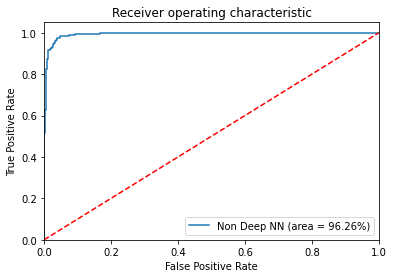

c:\Users\armag\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM
-------------------------------------
Classification Report for Training Data
              precision    recall  f1-score   support

    ABNORMAL       0.98      0.97      0.98      1663
      NORMAL       0.98      0.98      0.98      2335

    accuracy                           0.98      3998
   macro avg       0.98      0.98      0.98      3998
weighted avg       0.98      0.98      0.98      3998

-------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

    ABNORMAL       0.97      0.95      0.96       416
      NORMAL       0.96      0.98      0.97       584

    accuracy                           0.97      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.97      0.97      1000



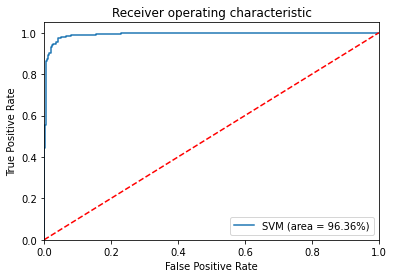

In [22]:

params = [
    {'classifier' : [LogisticRegression(random_state=42)], 'model_name' : ['Logistic Regression'],
    'param_grid': { 'logisticregression__penalty' : ['l1', 'l2', None], 'logisticregression__C' : np.logspace(-3,3,7), 'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear']}},
    {'classifier' : [RandomForestClassifier(random_state=42)], 'model_name' : ['Random Forest'],
    'param_grid': { 'randomforestclassifier__n_estimators' : list(range(10,100,200)), 'randomforestclassifier__max_depth' : [4,5,6,7,8], 'randomforestclassifier__criterion' :['gini', 'entropy']}}, 
    {'classifier' : [KNeighborsClassifier()], 'model_name' : ['K_Neighbors'],
    'param_grid': { 'kneighborsclassifier__weights': ['uniform','distance'],'kneighborsclassifier__n_neighbors': [2]}},
    {'classifier' : [XGBClassifier(random_state=42)], 'model_name' : ['XGBoost'],
    'param_grid': { 'xgbclassifier__learning_rate':  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'xgbclassifier__n_estimators': [100, 200, 300, 400, 500], 'xgbclassifier__gamma' : [0.5, 1.5]}},
    {'classifier' : [MLPClassifier(random_state=42)], 'model_name' : ['Non Deep NN'],
    'param_grid': { 'mlpclassifier__hidden_layer_sizes': [(10,30,10),(20,)], 'mlpclassifier__activation': ['tanh', 'relu'], 'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__alpha': [0.0001, 0.05], 'mlpclassifier__learning_rate': ['constant','adaptive'] }}, 
    {'classifier' : [SVC(random_state=42, probability=True)], 'model_name' : ['SVM'],
    'param_grid': { 'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'svc__kernel': ['rbf'] }}

]


# define a dataframe to save performance metrics
df_results = pd.DataFrame(columns=['model_name', 'Accuracy on training data', 'Accuracy on test data',
'Precision score on training data', 'Precision score  on test data', 
'Recall score on training data', 'Recall score  on test data', 
'F1 score on training data', 'F1 score  on test data', 
'Classification Report for Training Data', 
'Classification Report for Test Data', 
'best_params_'])

# train and test models
for model_params in params:
    model = model_params['classifier'][0]
    param_grid = model_params['param_grid']
    model_name = model_params['model_name'][0]
    result = train_test_model(model, param_grid, X_train, y_train, X_test, y_test, model_name)
    
    # df_results.loc[len(df_results.index)] = result
    df_results.loc[len(df_results.index)] = result

In [49]:
pd.set_option('display.max_colwidth', 3000)
# df_results.columns

# df_results = df_results.rename(columns={'model_name':'Model', 'Accuracy on test data': 'Accuracy', 'Precision score  on test data':'Precision', 'Recall score  on test data':'Recall','F1 score  on test data':'F1' }, errors="raise")

df_results.iloc[:, [0, 2, 4,6,8,11]]

,Model,Accuracy,Precision,Recall,F1,best_params_
0,Logistic Regression,0.919,0.919866,0.943493,0.931530,"{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}"
1,Random Forest,0.937,0.937815,0.955479,0.946565,"{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 10}"
2,K_Neighbors,0.947,0.955403,0.953767,0.954584,"{'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__weights': 'distance'}"
3,XGBoost,0.953,0.943802,0.977740,0.960471,"{'xgbclassifier__gamma': 0.5, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100}"
4,Non Deep NN,0.966,0.959866,0.982877,0.971235,"{'mlpclassifier__activation': 'tanh', 'mlpclassifier__alpha': 0.05, 'mlpclassifier__hidden_layer_sizes': (10, 30, 10), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__solver': 'adam'}"
5,SVM,0.966,0.964527,0.977740,0.971088,"{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}"


In [23]:
X, y = X_train,  y_train
X.head()

,t0,t1,t6,t7,t139
4090,-0.400858,-1.756140,-3.013662,-2.693538,-0.523589
1299,-0.165098,-3.005193,-1.838384,-1.579131,0.434638
4354,0.116986,-0.843915,-3.075198,-2.663583,-1.200763
2882,-1.954648,-3.529748,-1.867015,-1.634692,0.552678
1625,1.723749,0.518768,-3.005272,-1.938415,1.399340


LogisticRegression

In [25]:

m = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
# m.fit(X, y)
# # The estimated coefficients will all be around 1:
# print(m.coef_)

m.fit(X / np.std(X, 0), y)
print(m.coef_)


[[ 2.0712668  -3.09316885 -2.5180762   2.97150583  0.58111314]]


Random Forest	

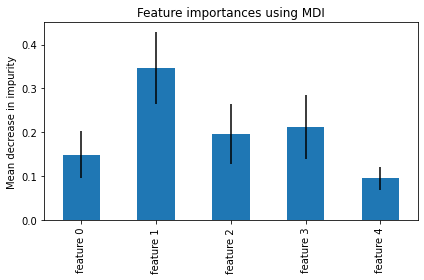

In [27]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=10)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

XGBRegressor

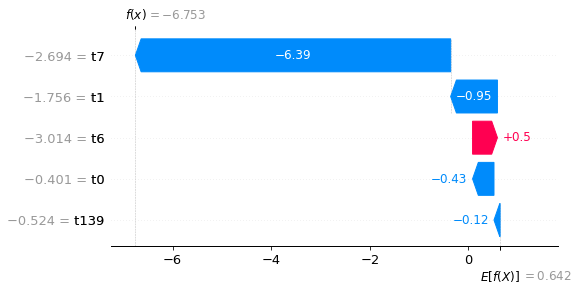

In [29]:
import shap

model = XGBClassifier().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])
